In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import math
from scipy.interpolate import interp1d

"""
CUIDADO!!
"""
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Para usar LaTex no PyPlot
# tive que instalar: > sudo apt-get install cm-super
params = {'text.usetex': True} 
plt.rcParams.update(params)

# Declaração das funções utilizadas

Modelo exponencial simples: $$ Volume(P_{aw}) = V_{max} \left( 1- e^{(-KP_{aw})} \right) $$

Função densidade de probabilidade (curva normal): $$ fdp(x) = \dfrac{1}{\sigma \sqrt{2\pi}} e^{-\dfrac{1}{2} \left( \dfrac{x-\mu}{\sigma} \right)^2} $$

Função densidade de probabilidade acumulada: integral da f.d.p.: $$ fda(x) = \int\limits_{-\infty}^{x} fdp(x) dx $$ 

Modelo sigmoide com base em unidades recrutadas: $$ Volume(P_{aw}) = V_{max} \; fda(P_{aw}) \left( 1- e^{(-KP_{aw})} \right)  $$

In [3]:
# Modelo exponencial simples de curva PV pulmonar
# Volume = Vmax*(1-e^(-K*Paw))
# Paw = pressão na via aérea
# K = 'constante de tempo' da exponencial
def exponencial_simples(Paw,K,Vmax):
    return Vmax*(1-np.exp(-K*Paw))

# função densidade de probabilidade (curva normal)
# mi: esperança
# sigma: desvio padrão
def fdp(x,mi,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-0.5)*((x-mi)/sigma)**2)

# função densidade de probabilidade acumulada (integral da curva normal)
# mi: esperança
# sigma: desvio padrão
def fda(x,mi,sigma,dt=0.1):
    x_vec = np.arange(mi-6*sigma,x,dt)
    integral = 0
    for x in x_vec:
        integral = integral + fdp(x,mi,sigma)*dt
    return integral

# Modelo sigmoide da curva PV pulmonar
# Segue modelo exponencial, mas Vmax varia com a pressão
# Paw = pressão na via aérea
# K = 'constante de tempo' da exponencial
def modelo_sigmoide(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = Vmax*fda(Paw,mi,sigma)
    return Vmax_recrutado*(1-np.exp(-K*Paw))

# modelo de unidades recrutadas com erf()
def meu_erf(Paw,mi,sigma): # parâmetros ajustados empiricamente... ;)
    x = (Paw-mi)/(sigma*1.5)
    merf = math.erf(x)
    return (merf/2)+0.5

def modelo_sigmoide_erf(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = Vmax*meu_erf(Paw,mi,sigma)
    V = Vmax_recrutado*(1-np.exp(-K*Paw))
    return V

# modelo de unidades recrutadas com erf()
# ajustando a função para uma entrada array (para curve_fit)
def meu_erf_vec(Paw,mi,sigma):
    saida_lst = []
    for x_in in Paw:
        x = (x_in-mi)/(sigma*1.5)
        merf = math.erf(x)
        saida_lst.append((merf/2)+0.5)
    return np.array(saida_lst)

def modelo_sigmoide_erf_vec(Paw,K,Vmax,mi,sigma):
    Vmax_recrutado = Vmax*meu_erf_vec(Paw,mi,sigma)
    V = Vmax_recrutado*(1-np.exp(-K*Paw))
    return V

# Plotando funções usadas
## Comparando modelos sigmoides baseados em unidades recrutadas

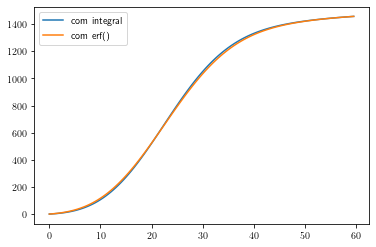

In [4]:
# comparando o modelo com integral e o com erf()
Pmax = 60
Vmax = 1500
K = 0.06
mi = 20
sigma = 10
pressoes = np.arange(0,Pmax,0.5)
sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
sigmoide2 = [modelo_sigmoide_erf(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
plt.plot(pressoes,sigmoide,label='com integral')
plt.plot(pressoes,sigmoide2,label='com erf()')
plt.legend()
plt.show()

## Testes sem interpolação

In [5]:
def plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax):
    Vmax_lst = np.arange(Vmax/10,Vmax+1,Vmax/10)
    pressoes = np.arange(0,Pmax,0.5)
    sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]

    plt.figure(figsize=(15,5))
    plt1 = plt.subplot(1,2,1)
    for Vmax in Vmax_lst:
        volumes = [exponencial_simples(Paw,K,Vmax) for Paw in pressoes]
        plt.plot(pressoes,volumes,'k:')
    plt.plot(pressoes,sigmoide,label=f'sig: K={K:.3f}, Vmax={Vmax:.0f}, $\\mu$={mi:.1f}, $\\sigma$={sigma:.1f}')
    plt.xlabel('Pressão ($cmH_2O$)')
    plt.ylabel('Volume ($mL$)')
    plt.title(r'Modelo pulmonar sigmoide')
    plt2 = plt.subplot(1,2,2)
    prob = [fdp(Paw,mi,sigma) for Paw in pressoes]
    plt.plot(pressoes,prob,label='sig')
    plt.xlabel('Pressão crítica de abertura ($cmH_2O$)')
    plt.ylabel('Probabilidade')
    plt.title('Probabilidade de novas unidades pulmonares recrutadas')
    return plt1, plt2

In [6]:
# p0 = estimativa inicial: [K,Vmax,mi,sigma]
def testa_ajuste(Pmax,Vmax,K,mi,sigma,pressoes,p0=[0.05, 2000, 10, 10],estimator="trf"):

    # plotando valores 'reais'
    vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
    plt1,_ = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
    _= plt1.scatter(pressoes,vol_sigmoide)
    
    # ajustando parâmetros
    parameters, pcov = curve_fit(modelo_sigmoide_erf_vec, pressoes, vol_sigmoide, p0=p0, method=estimator)
    vol_sigmoide_fitado = [modelo_sigmoide(x,*parameters) for x in range(Pmax)]
    K,Vmax,mi,sigma = parameters
    _= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',label=f'fit: K={K:.3f}, Vmax={Vmax:.0f}, $\\mu$={mi:.1f}, $\\sigma$={sigma:.1f}')
    plt1.legend()
    

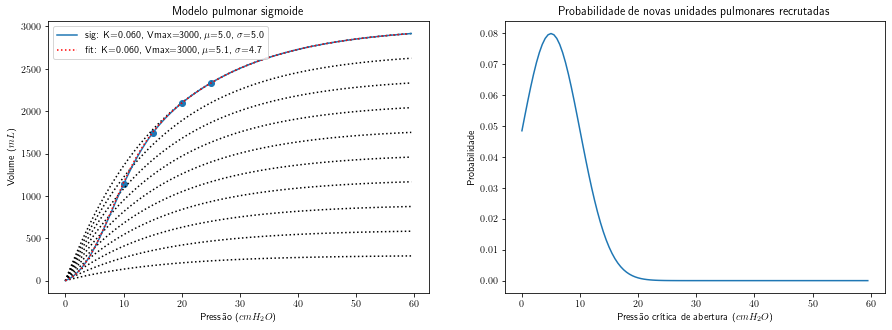

In [7]:
pressoes = [10, 15, 20, 25]
testa_ajuste(60,3000,0.06,5,5,pressoes) # Pmax,Vmax,K,mi,sigma,pressoes

## Testes com interpolação

In [8]:
# interpola vetores PV
# n_points = número de pontos intermediários
def interpola_PV(pressoes,volumes,n_points=0):
    interp_pressures = np.linspace(pressoes[0], pressoes[-1], (len(pressoes)*(n_points+1))-n_points, endpoint=True)
    interp_func = interp1d(pressoes, volumes, kind="linear")
    interp_volumes = interp_func(interp_pressures)
    return interp_pressures, interp_volumes
    

# p0 = estimativa inicial: [K,Vmax,mi,sigma]
def testa_ajuste_interpolado(Pmax,Vmax,K,mi,sigma,pressoes,p0=[0.05, 2000, 10, 10],estimator="trf",n_points=0):
    try:
        meus_bounds = ([0.02,100,0,2],[0.08,5000,40,40])

        # plotando valores 'reais'
        vol_sigmoide = [modelo_sigmoide(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
        plt1,plt2 = plot_curvas_sigmoide(Pmax,mi,sigma,K,Vmax)
        _= plt1.scatter(pressoes,vol_sigmoide)

        # interpolando
        interp_pressures, interp_volumes = interpola_PV(pressoes,vol_sigmoide,n_points)
        _= plt1.scatter(interp_pressures,interp_volumes,c='r',marker='x')

        # ajustando parâmetros
        parameters, pcov = curve_fit(modelo_sigmoide_erf_vec,
                                     interp_pressures,
                                     interp_volumes,
                                     p0=p0,
                                     method=estimator,
                                     bounds=meus_bounds)
        vol_sigmoide_fitado = [modelo_sigmoide(x,*parameters) for x in range(Pmax)]
        K,Vmax,mi,sigma = parameters
        _= plt1.plot(range(Pmax),vol_sigmoide_fitado,'r:',label=f'fit: K={K:.3f}, Vmax={Vmax:.0f}, $\\mu$={mi:.1f}, $\\sigma$={sigma:.1f}')
        plt1.legend()
        prob = [fdp(Paw,mi,sigma) for Paw in pressoes]
        fda_fit = [fdp(x,mi,sigma) for x in range(Pmax)]
        _= plt2.plot(range(Pmax),fda_fit,'r:',label='fit')
        plt2.legend()
    except:
        print(f'Não fitou com {n_points} pontos.')
    

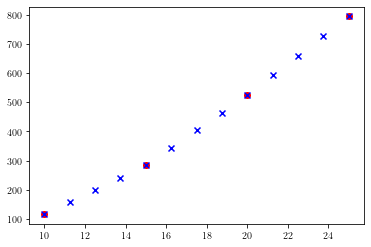

In [9]:
Paw, K, Vmax, mi, sigma = 60, 0.06, 1500, 20, 10
pressoes = [10, 15, 20, 25]
volumes = [modelo_sigmoide_erf(Paw,K,Vmax,mi,sigma) for Paw in pressoes]
interp_pressures, interp_volumes = interpola_PV(pressoes,volumes,n_points=3)
plt.scatter(pressoes,volumes,c='r')
plt.scatter(interp_pressures,interp_volumes,c='b',marker='x')
plt.show()

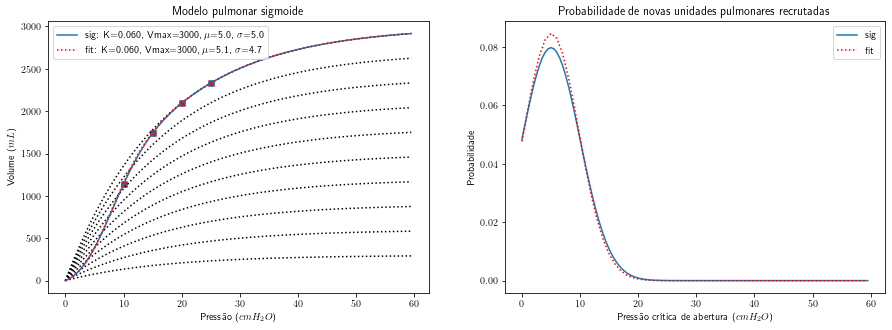

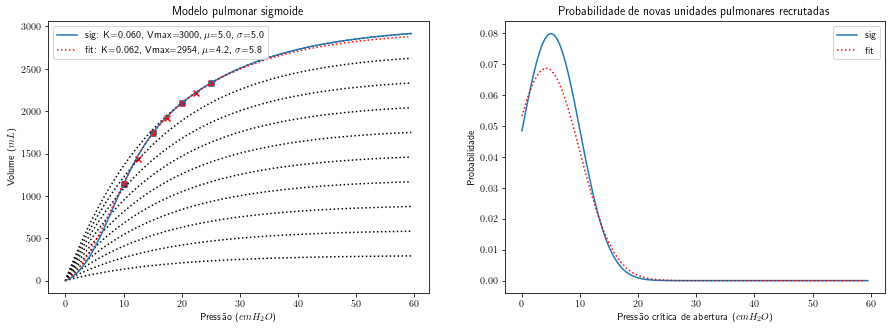

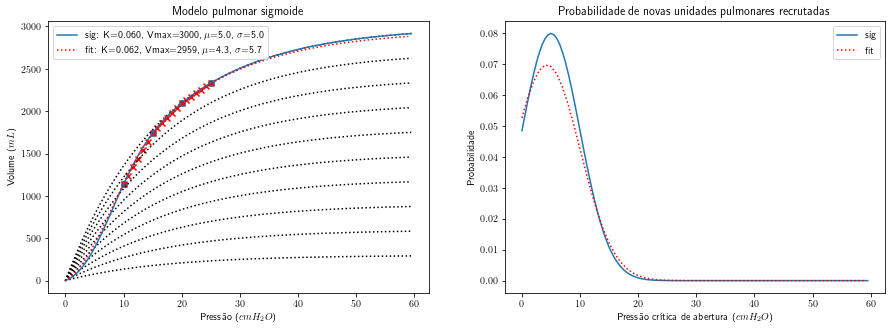

In [10]:
pressoes = [10, 15, 20, 25]
for n_points in [0,1,5]:
    testa_ajuste_interpolado(60,3000,0.06,5,5,pressoes,n_points=n_points) # Pmax,Vmax,K,mi,sigma,pressoes

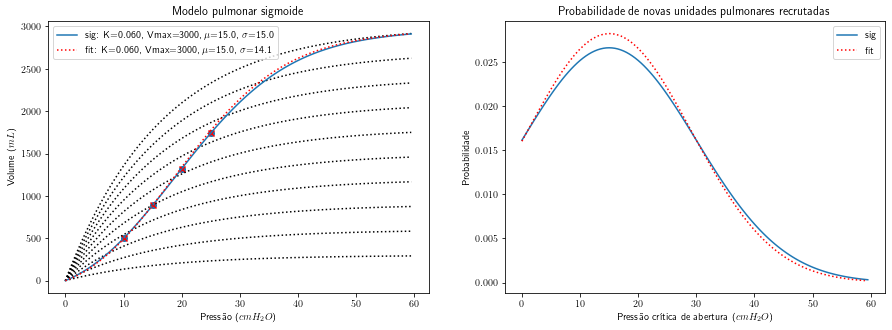

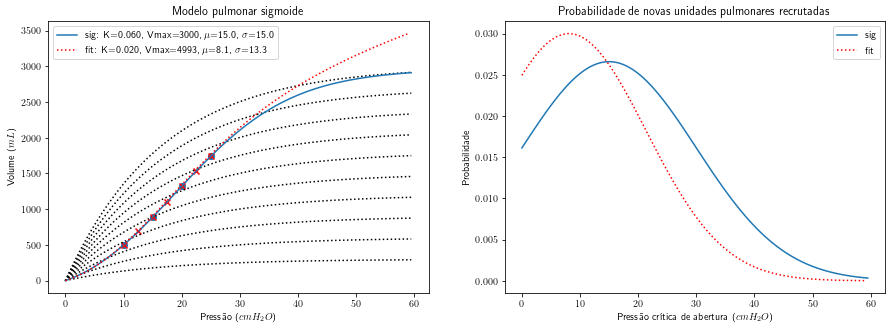

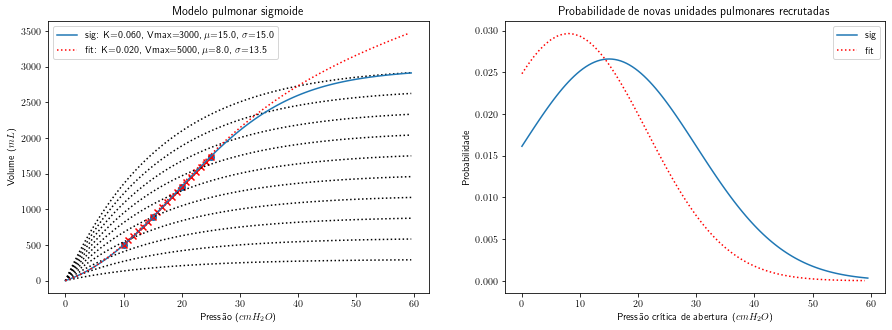

In [11]:
pressoes = [10, 15, 20, 25]
for n_points in [0,1,5]:
    testa_ajuste_interpolado(60,3000,0.06,15,15,pressoes,n_points=n_points) # Pmax,Vmax,K,mi,sigma,pressoes

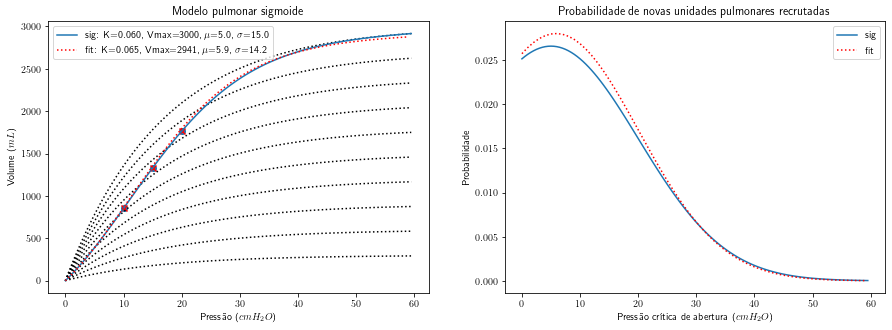

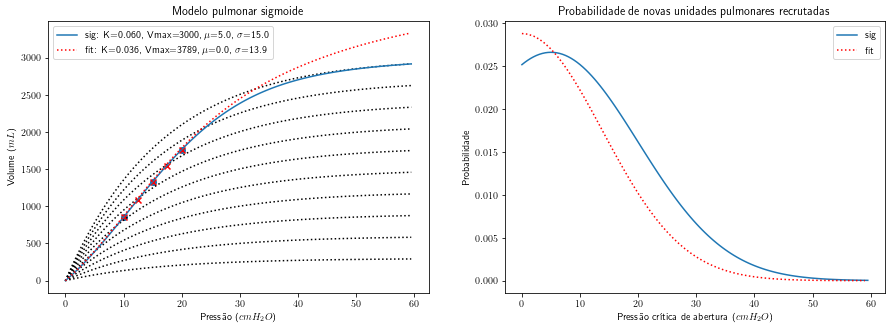

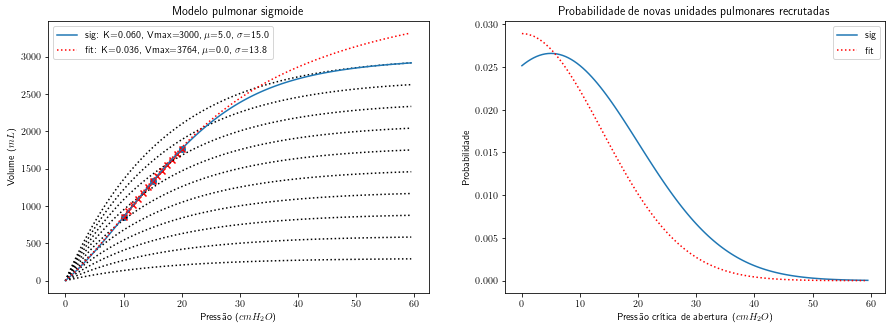

In [12]:
pressoes = [10, 15, 20]
for n_points in [0,1,5]:
    testa_ajuste_interpolado(60,3000,0.06,5,15,pressoes,n_points=n_points) # Pmax,Vmax,K,mi,sigma,pressoes

Não fitou com 0 pontos.


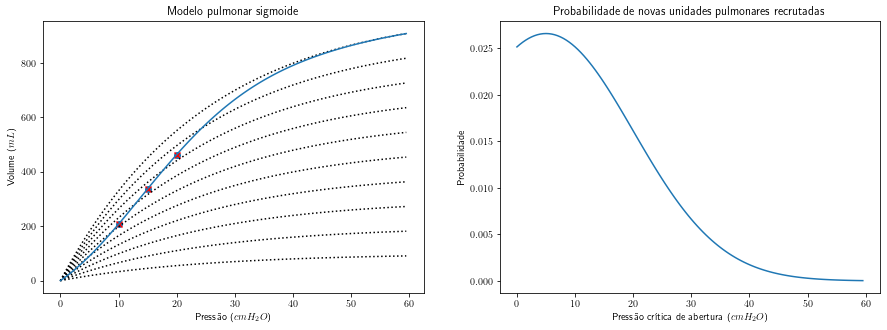

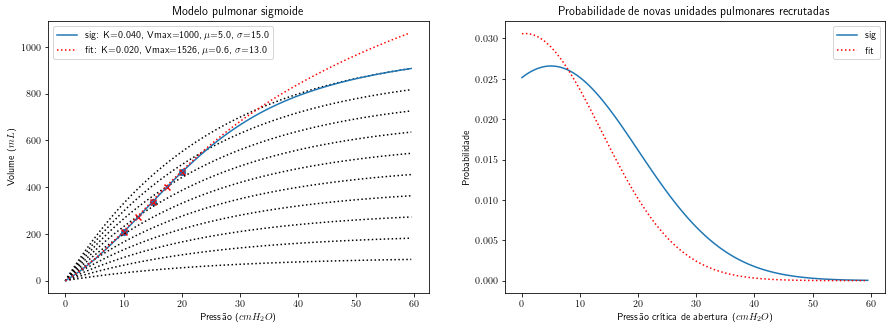

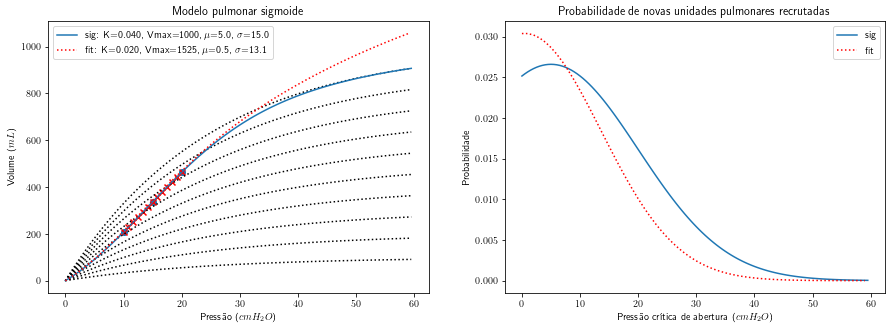

In [13]:
pressoes = [10, 15, 20]
for n_points in [0,1,5]:
    testa_ajuste_interpolado(60,1000,0.04,5,15,pressoes,n_points=n_points) # Pmax,Vmax,K,mi,sigma,pressoes